## Importing Modules

In [1]:
# general
import pandas as pd
import numpy as np
import random
import os
import pickle
import glob
import time
from datetime import timedelta, date
from dateutil import parser

#modeling
from sklearn import metrics, exceptions, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, precision_score, roc_curve, auc
from sklearn.metrics import recall_score, f1_score, fbeta_score, accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Value

### Data pre-processing

In [31]:
master = pd.read_csv('../data/master.csv').drop(['Unnamed: 0'], axis=1)
master['event'] = (master['event'] == 'YES').astype(int)
master.head()

,batter_name,batter_BB,batter_K,batter_AVG,batter_OBP,batter_SLG,batter_ISO,batter_wRC,batter_wRAA,batter_wOBA,...,split_pitcher_OBP,split_pitcher_SLG,split_pitcher_ISO,split_pitcher_WHIP,split_pitcher_FIP,split_pitcher_LD,split_pitcher_FB,split_pitcher_HRFB,HZ_Score,event
0,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.419183,0.399777,0.145880,2.199052,3.868374,0.241963,0.214890,0.149606,126,0
1,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.437288,0.487069,0.301724,2.295181,5.647414,0.192513,0.347594,0.123077,21,0
2,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.375445,0.411111,0.191111,1.812317,4.786667,0.218750,0.256944,0.297297,193,0
3,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.401862,0.443603,0.213805,1.978339,3.733838,0.295063,0.234214,0.117647,157,0
4,A.J. Ellis,0.110599,0.208909,0.219251,0.324074,0.360071,0.185383,69.99664,-7.998203,0.30338,...,0.401862,0.443603,0.213805,1.978339,3.733838,0.295063,0.234214,0.117647,157,0


In [32]:
master.shape

(139197, 49)

In [33]:
X = master.loc[:, 'batter_BB':'HZ_Score']
y = master.loc[:, 'event']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# create polynomial features
poly_degree = 2

# normalize data
std = StandardScaler()

# split polynomial features
pf = PolynomialFeatures(degree = poly_degree)
features = master.loc[:, 'batter_BB':'HZ_Score'].columns.tolist()
pf.fit(master[features])
feat_array = pf.transform(master[features])
master_poly = pd.DataFrame(feat_array, columns = pf.get_feature_names(input_features=features))
X_poly = master_poly.loc[:,pf.get_feature_names(input_features=features)]
y_poly = master['event']
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

# transform linear features
std.fit(X_train.values)
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

# transform polynomial features
std.fit(X_poly_train.values)
X_poly_tr = std.transform(X_poly_train.values)
X_poly_te = std.transform(X_poly_test.values)

### Cross-validation for model selection

#### Base model

(2.0, 0.0)


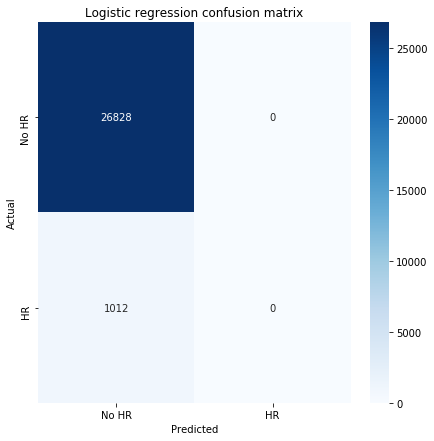

In [35]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_tr, y_train)

logit_confusion = confusion_matrix(y_test, logit.predict(X_te))

plt.figure(figsize = (7,7))
ax = sns.heatmap(logit_confusion, annot=True, cmap='Blues', fmt='g', xticklabels=['No HR', 'HR'], yticklabels=['No HR', 'HR'])
print(ax.get_ylim())
ax.set_ylim(2.0, 0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic regression confusion matrix');

In [36]:
lr = LogisticRegression(solver='liblinear')
gnb = GaussianNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
scaled_models = [lr, gnb]
unscaled_models = [dt, rf]

In [37]:
threshold = 0.5

In [39]:
base_metrics = []
base_unscaled_metrics = []

for val_model in scaled_models:
    val_model.fit(X_tr, y_train);
    preds = val_model.predict_proba(X_te)[:,1] >= threshold
    model_CV = np.mean(cross_val_score(val_model, X_tr, y_train, cv=2))
    model_acc = accuracy_score(y_test, preds)
    model_prec = precision_score(y_test, preds)
    model_rec = recall_score(y_test, preds)
    model_f1 = f1_score(y_test, preds)
    base_metrics.append([str(val_model)[0:5], model_CV, model_acc, model_prec, model_rec, model_f1])
    
for val_model in unscaled_models:
    val_model.fit(X_train, y_train);
    preds = val_model.predict_proba(X_test)[:,1] >= threshold
    model_CV = np.mean(cross_val_score(val_model, X_train, y_train, cv=2))
    model_acc = accuracy_score(y_test, preds)
    model_prec = precision_score(y_test, preds)
    model_rec = recall_score(y_test, preds)
    model_f1 = f1_score(y_test, preds)
    base_unscaled_metrics.append([str(val_model)[0:5], model_CV, model_acc, model_prec, model_rec, model_f1])
    
model_selection = pd.DataFrame(base_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
base_selection_unscaled = pd.DataFrame(base_unscaled_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_selection = model_selection.append(base_selection_unscaled)
model_selection = model_selection.sort_values(by=['Recall'], ascending=False).head(len(scaled_models)*6).reset_index().drop(['index'], axis=1)
model_selection.head(20)

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,model,CV,Accuracy,Precision,Recall,F1
0,Gauss,0.810941,0.813290,0.065587,0.312253,0.108405
1,Decis,0.934382,0.923815,0.012313,0.013834,0.013029
2,Logis,0.962068,0.963649,0.000000,0.000000,0.000000
3,Rando,0.948373,0.948348,0.000000,0.000000,0.000000


#### Class imbalance issues

0    0.962377
1    0.037623
Name: event, dtype: float64
0    133960
1      5237
Name: event, dtype: int64


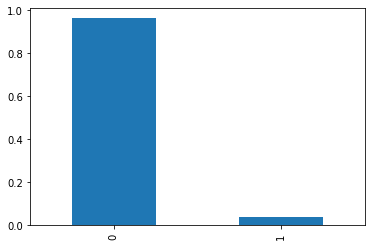

In [41]:
target_pcts = master.event.value_counts(normalize=True) 
print(target_pcts)
print(master.event.value_counts())
target_pcts.plot(kind='bar');

In [43]:
X_train.shape

(111357, 47)

In [44]:
# Combine majority class with upsampled minority class
df_sampling = X_train.copy()
df_sampling['event'] = y_train.values
df_sampling.head()

,batter_BB,batter_K,batter_AVG,batter_OBP,batter_SLG,batter_ISO,batter_wRC,batter_wRAA,batter_wOBA,batter_LD,...,split_pitcher_OBP,split_pitcher_SLG,split_pitcher_ISO,split_pitcher_WHIP,split_pitcher_FIP,split_pitcher_LD,split_pitcher_FB,split_pitcher_HRFB,HZ_Score,event
37324,0.115836,0.165689,0.257703,0.346758,0.420168,0.233053,267.168707,23.469330,0.331650,0.298064,...,0.296020,0.410326,0.250000,1.270463,3.540217,0.278810,0.226766,0.196721,137,0
90320,0.160071,0.326639,0.182206,0.312905,0.402847,0.266192,191.845274,-10.692437,0.310484,0.197183,...,0.304659,0.416557,0.219448,1.275387,3.825361,0.268571,0.287619,0.231788,169,0
64453,0.156420,0.261479,0.228119,0.348402,0.418994,0.226257,170.934613,17.972996,0.334644,0.269648,...,0.257006,0.345196,0.167972,1.025806,2.333452,0.228542,0.203723,0.142132,106,0
83879,0.080486,0.205486,0.235324,0.304766,0.375506,0.195344,224.775401,-42.111232,0.295467,0.234365,...,0.242712,0.297650,0.164118,0.934871,1.967587,0.245925,0.281361,0.168766,135,0
24895,0.180903,0.183141,0.245782,0.384701,0.419517,0.245326,404.055148,86.353453,0.356329,0.253819,...,0.368715,0.443694,0.231982,1.711712,5.586486,0.263889,0.191667,0.333333,105,0


In [45]:
df_majority = df_sampling[df_sampling.event==0]
df_minority = df_sampling[df_sampling.event==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True,
                                 n_samples=df_sampling.event.value_counts()[0],
                                 random_state=123)
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.head()

,batter_BB,batter_K,batter_AVG,batter_OBP,batter_SLG,batter_ISO,batter_wRC,batter_wRAA,batter_wOBA,batter_LD,...,split_pitcher_OBP,split_pitcher_SLG,split_pitcher_ISO,split_pitcher_WHIP,split_pitcher_FIP,split_pitcher_LD,split_pitcher_FB,split_pitcher_HRFB,HZ_Score,event
37324,0.115836,0.165689,0.257703,0.346758,0.420168,0.233053,267.168707,23.469330,0.331650,0.298064,...,0.296020,0.410326,0.250000,1.270463,3.540217,0.278810,0.226766,0.196721,137,0
90320,0.160071,0.326639,0.182206,0.312905,0.402847,0.266192,191.845274,-10.692437,0.310484,0.197183,...,0.304659,0.416557,0.219448,1.275387,3.825361,0.268571,0.287619,0.231788,169,0
64453,0.156420,0.261479,0.228119,0.348402,0.418994,0.226257,170.934613,17.972996,0.334644,0.269648,...,0.257006,0.345196,0.167972,1.025806,2.333452,0.228542,0.203723,0.142132,106,0
83879,0.080486,0.205486,0.235324,0.304766,0.375506,0.195344,224.775401,-42.111232,0.295467,0.234365,...,0.242712,0.297650,0.164118,0.934871,1.967587,0.245925,0.281361,0.168766,135,0
24895,0.180903,0.183141,0.245782,0.384701,0.419517,0.245326,404.055148,86.353453,0.356329,0.253819,...,0.368715,0.443694,0.231982,1.711712,5.586486,0.263889,0.191667,0.333333,105,0


In [46]:
target_pcts = df_upsampled.event.value_counts(normalize=True) 
print(target_pcts)
print(df_upsampled.event.value_counts())

1    0.5
0    0.5
Name: event, dtype: float64
1    107132
0    107132
Name: event, dtype: int64


In [47]:
X_upsampled = df_upsampled.loc[:, 'batter_BB':'HZ_Score']
y_upsampled = df_upsampled.loc[:, 'event']

In [48]:
X_upsampled_train, X_test_unused, y_upsampled_train, y_test_unused = train_test_split(X_upsampled, y_upsampled, test_size=0.2,random_state=42)

# normalize data
std = StandardScaler()

# transform linear features
std.fit(X_upsampled_train.values)
X_upsampled_tr = std.transform(X_upsampled_train.values)

#### Base model

(2.0, 0.0)


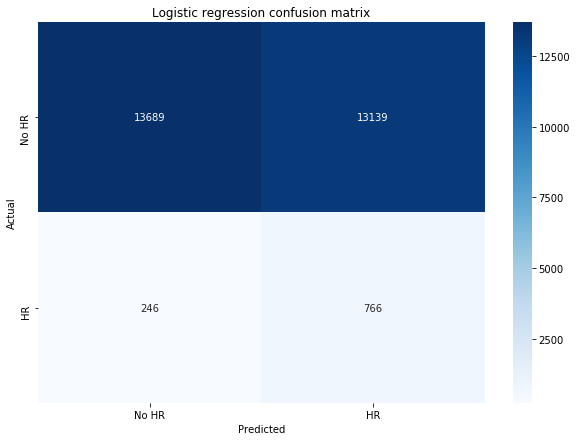

In [49]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_upsampled_tr, y_upsampled_train)

logit_confusion = confusion_matrix(y_test, logit.predict(X_te))

plt.figure(figsize = (10,7))
ax = sns.heatmap(logit_confusion, annot=True, cmap='Blues', fmt='g', xticklabels=['No HR', 'HR'], yticklabels=['No HR', 'HR'])
print(ax.get_ylim())
ax.set_ylim(2.0, 0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic regression confusion matrix');

In [50]:
upsampled_metrics = []
upsampled_unscaled_metrics = []

for val_model in scaled_models:
    val_model.fit(X_upsampled_tr, y_upsampled_train);
    preds = val_model.predict_proba(X_te)[:,1] >= threshold
    model_CV = np.mean(cross_val_score(val_model, X_upsampled_tr, y_upsampled_train, cv=2))
    model_acc = accuracy_score(y_test, preds)
    model_prec = precision_score(y_test, preds)
    model_rec = recall_score(y_test, preds)
    model_f1 = f1_score(y_test, preds)
    upsampled_metrics.append([str(val_model)[0:5] + str(' upsamp'), model_CV, model_acc, model_prec, model_rec, model_f1])
    
for val_model in unscaled_models:
    val_model.fit(X_upsampled_train, y_upsampled_train);
    preds = val_model.predict_proba(X_test)[:,1] >= threshold
    model_CV = np.mean(cross_val_score(val_model, X_upsampled_train, y_upsampled_train, cv=2))
    model_acc = accuracy_score(y_test, preds)
    model_prec = precision_score(y_test, preds)
    model_rec = recall_score(y_test, preds)
    model_f1 = f1_score(y_test, preds)
    upsampled_unscaled_metrics.append([str(val_model)[0:5] + str(' upsamp'), model_CV, model_acc, model_prec, model_rec, model_f1])
    
upsampled_selection = pd.DataFrame(upsampled_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
upsampled_selection_unscaled = pd.DataFrame(upsampled_unscaled_metrics, columns = ['model', 'CV', 'Accuracy', 'Precision', 'Recall', 'F1'])
model_selection = model_selection.append(upsampled_selection)
model_selection = model_selection.append(upsampled_selection_unscaled)
model_selection = model_selection.sort_values(by=['F1'], ascending=False).head(len(scaled_models)*6).reset_index().drop(['index'], axis=1)
model_selection.head(20)

,model,CV,Accuracy,Precision,Recall,F1
0,Gauss,0.810941,0.813290,0.065587,0.312253,0.108405
1,Logis upsamp,0.637345,0.519253,0.055092,0.756917,0.102709
2,Gauss upsamp,0.610778,0.538182,0.051631,0.673913,0.095914
3,Decis upsamp,0.935168,0.878089,0.011084,0.026680,0.015661
4,Decis,0.934382,0.923815,0.012313,0.013834,0.013029
5,Rando upsamp,0.958999,0.896228,0.001593,0.002964,0.002073
6,Logis,0.962068,0.963649,0.000000,0.000000,0.000000
7,Rando,0.948373,0.948348,0.000000,0.000000,0.000000


(8.0, 0.0)


(10.0, 0)

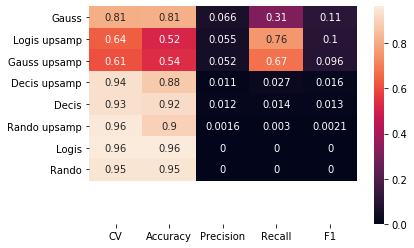

In [51]:
ax = sns.heatmap(model_selection.loc[:,'CV':'F1'], yticklabels=model_selection['model'], annot=True)
print(ax.get_ylim())
ax.set_ylim(10.0, 0)

## Testing

In [52]:
val_model = lr
upsampled = True

In [53]:
if upsampled:
    X_train_val = X_upsampled_train
    y_train_val = y_upsampled_train

In [86]:
# normalize data
std = StandardScaler()

# transform linear features
std.fit(X_train.values)
X_tr_val = std.transform(X_train.values)
X_te_val = std.transform(X_test.values)

In [54]:
if val_model in scaled_models:
    val_model.fit(X_tr, y_train);
    X_tr, X_val, y_train, y_val = train_test_split(X_tr, y_train, test_size=0.25,random_state=42)
else:
    val_model.fit(X_train, y_train);
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,random_state=42)

c:\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Logismodel best f_beta 0.137 at prob decision threshold >= 0.074


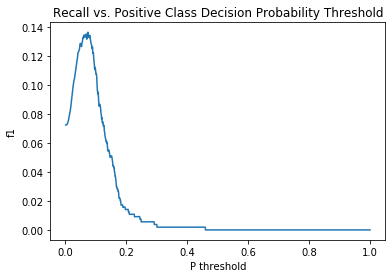

In [57]:
thresh_ps = np.linspace(.001,1.0,1000)
model_val_probs = val_model.predict_proba(X_val)[:,1]

f1_scores = []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(fbeta_score(y_val, model_val_labels, 1))
    
plt.plot(thresh_ps, f1_scores)
plt.title('Recall vs. Positive Class Decision Probability Threshold')
plt.xlabel('P threshold')
plt.ylabel('f1')

best_f1_score = np.max(f1_scores) 
best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print(str(val_model)[0:5] + 'model best f_beta %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))

In [58]:
threshold = best_thresh_p

(2.0, 0.0)


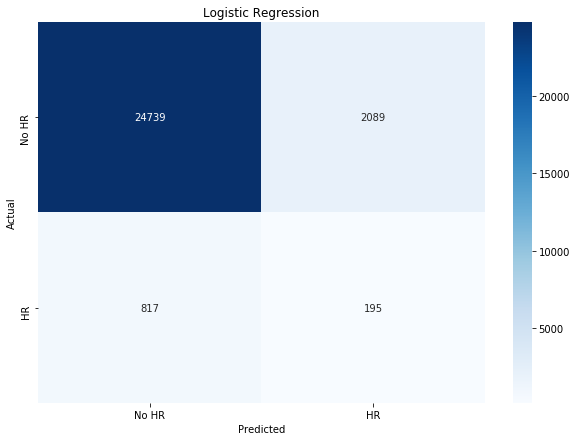

In [59]:
if val_model in scaled_models:
    logit_confusion = confusion_matrix(y_test, val_model.predict_proba(X_te)[:,1] >= threshold)
else:
    logit_confusion = confusion_matrix(y_test, val_model.predict_proba(X_test)[:,1] >= threshold)

plt.figure(figsize = (10,7))
ax = sns.heatmap(logit_confusion, annot=True, cmap='Blues', fmt='g', xticklabels=['No HR', 'HR'], yticklabels=['No HR', 'HR'])
print(ax.get_ylim())
ax.set_ylim(2.0, 0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression');

In [62]:
poly = 0

In [63]:
val_model.fit(X_tr, y_train);
    
# This will display coefficients, unless using a tree-based model
if val_model != rf:    
    
    if poly:
        coef = [item for sublist in val_model.coef_ for item in sublist];
        variables = master_poly.columns.to_list()
        master_coef = pd.DataFrame()
        master_coef['Variable'] = variables
        master_coef['Coef'] = coef
    
    else:
        coef = [item for sublist in val_model.coef_ for item in sublist];
        variables = master.loc[:, 'batter_BB':'HZ_Score'].columns.to_list()
        master_coef = pd.DataFrame()
        master_coef['Variable'] = variables
        master_coef['Coef'] = coef

master_coef = master_coef[master_coef['Coef'] != 0].sort_values(by=['Coef'], ascending=False)
master_coef.head(master_coef.shape[0]).reset_index().drop(['index'], axis=1)

,Variable,Coef
0,batter_wOBA,0.540560
1,split_batter_SLG,0.442153
2,split_pitcher_SLG,0.362062
3,split_batter_HRFB,0.318707
4,split_batter_OBP,0.289734
5,split_pitcher_FIP,0.271039
6,split_pitcher_AVG,0.241828
7,pitcher_ISO,0.229894
8,pitcher_AVG,0.181576
9,pitcher_HRFB,0.178978


### Value model selection

In [901]:
val_model = lr
upsampled = True

### Save model

In [65]:
with open('../models/class_model.pkl', 'wb') as file:
    pickle.dump(val_model, file)
    
X_train_val.to_csv('../models/class_data.csv', index=False)

### XGB

In [93]:
val_model = xgb.Booster()
val_model.load_model("../models/gbm_model.model")

(2.0, 0.0)


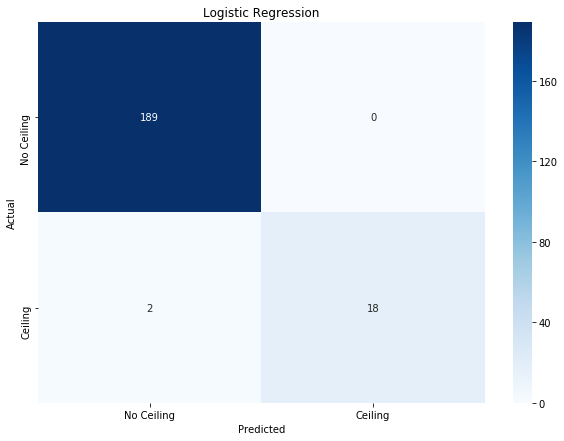

In [96]:
logit_confusion = confusion_matrix(y_test_val, val_model.predict(xgb.DMatrix(X_test_val)) >= threshold)

plt.figure(figsize = (10,7))
ax = sns.heatmap(logit_confusion, annot=True, cmap='Blues', fmt='g', xticklabels=['No Ceiling', 'Ceiling'], yticklabels=['No Ceiling', 'Ceiling'])
print(ax.get_ylim())
ax.set_ylim(2.0, 0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression');